# Anomaly Detection for Software Vulnerabilities 
## An approach to evaluate a data set if it represents normal behaviour



## Explorative Data Analysis

### Meta Information


In [79]:
# Imports 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import matplotlib.dates as mdates

from helpers import *
from predict import *
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_curve, auc, 
    precision_score,
    roc_auc_score,
    recall_score,
    brier_score_loss, 
    f1_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay)

from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
import warnings  
warnings.filterwarnings('ignore')

init_notebook_mode(connected=True)

In [31]:
# Load Data
train = pd.read_pickle("/Users/janavihs/projects/anomaly-detection-software/data/interim/raw/train.pkl")
test = pd.read_pickle("/Users/janavihs/projects/anomaly-detection-software/data/interim/raw/test.pkl")
validation = pd.read_pickle("/Users/janavihs/projects/anomaly-detection-software/data/interim/raw/validation.pkl")

In [32]:
print(train.shape)
print(test.shape)
print(validation.shape)

(9564, 14)
(39927, 14)
(2603, 14)


### Distributions

Text(0.5, 1.0, 'Memory Usage Distribution Train Data')

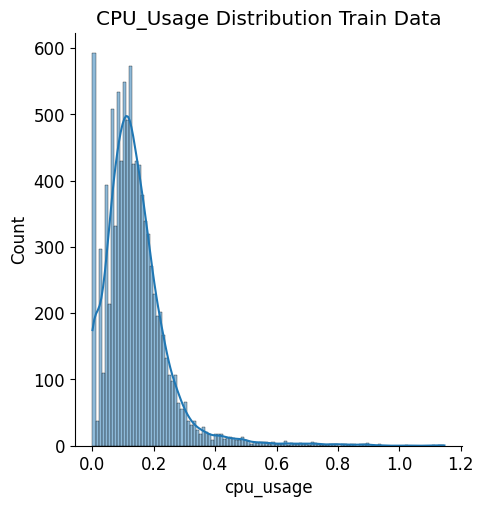

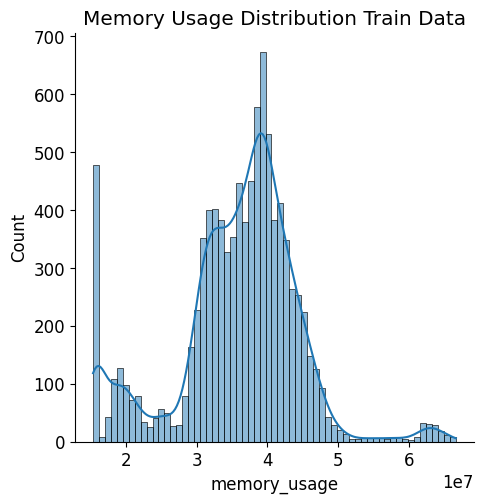

In [33]:
# Distribution Plot Train Data 
sns.displot(data=train, x='cpu_usage', kde=True)
plt.title('CPU_Usage Distribution Train Data')
sns.displot(data=train, x='memory_usage', kde=True)
plt.title('Memory Usage Distribution Train Data')

In [34]:
# Statistical Table
train.describe()

,cpu_usage,memory_usage,network_received,network_send,storage_read,storage_written
count,9564.000000,9.564000e+03,9564.000000,9564.000000,9564.000000,9564.000000
mean,0.141092,3.586510e+07,4084.739753,16489.362087,67.238812,154.606441
std,0.107538,8.686077e+06,3197.226831,29075.417379,4265.001791,1107.688249
min,0.000277,1.531904e+07,0.000000,0.000000,0.000000,0.000000
25%,0.076871,3.189555e+07,2091.000000,6932.000000,0.000000,0.000000
50%,0.123746,3.720806e+07,3485.000000,11631.000000,0.000000,0.000000
75%,0.181755,4.089446e+07,5227.000000,18469.000000,0.000000,0.000000
max,1.146535,6.668288e+07,28425.000000,354543.000000,356352.000000,20480.000000


In [35]:
test.describe()

,cpu_usage,memory_usage,network_received,network_send,storage_read,storage_written
count,39927.000000,3.992700e+04,39927.000000,39927.000000,3.992700e+04,3.992700e+04
mean,0.141173,3.568852e+07,4121.127733,16244.512260,3.506431e+02,2.255893e+02
std,0.111868,8.876811e+06,3479.540021,29279.070981,1.623316e+04,1.177772e+04
min,0.000129,1.361920e+07,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,0.071625,3.198566e+07,2090.000000,5374.500000,0.000000e+00,0.000000e+00
50%,0.125114,3.719578e+07,3485.000000,11593.000000,0.000000e+00,0.000000e+00
75%,0.184521,4.099277e+07,5395.000000,18557.500000,0.000000e+00,0.000000e+00
max,2.314982,7.683277e+07,35819.000000,614079.000000,1.503232e+06,2.342912e+06


Text(0.5, 1.0, 'Distribution Plot Memory Usage Test Data  ')

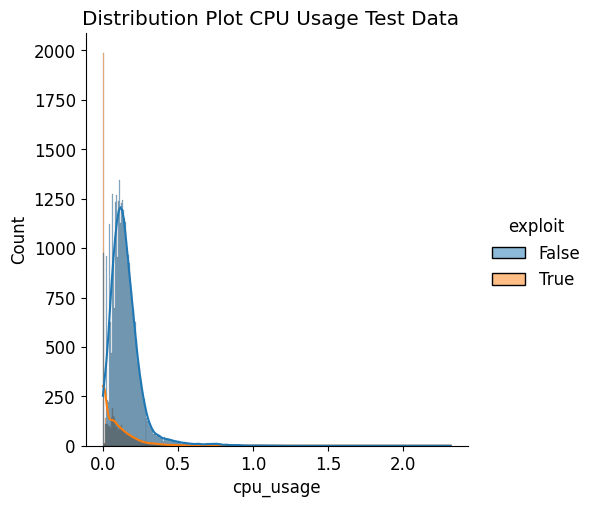

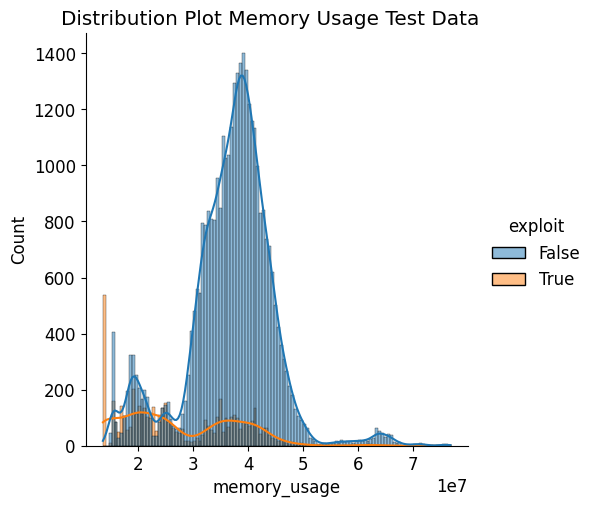

In [36]:
# Eventuell doch clustering ?
sns.displot(data=test, x='cpu_usage', hue='exploit', kde=True)
plt.title("Distribution Plot CPU Usage Test Data  ")
sns.displot(data=test, x='memory_usage', hue='exploit', kde=True)
plt.title("Distribution Plot Memory Usage Test Data  ")

### Correlation

Text(0.5, 1.0, 'Correlation between Features in Test Data')

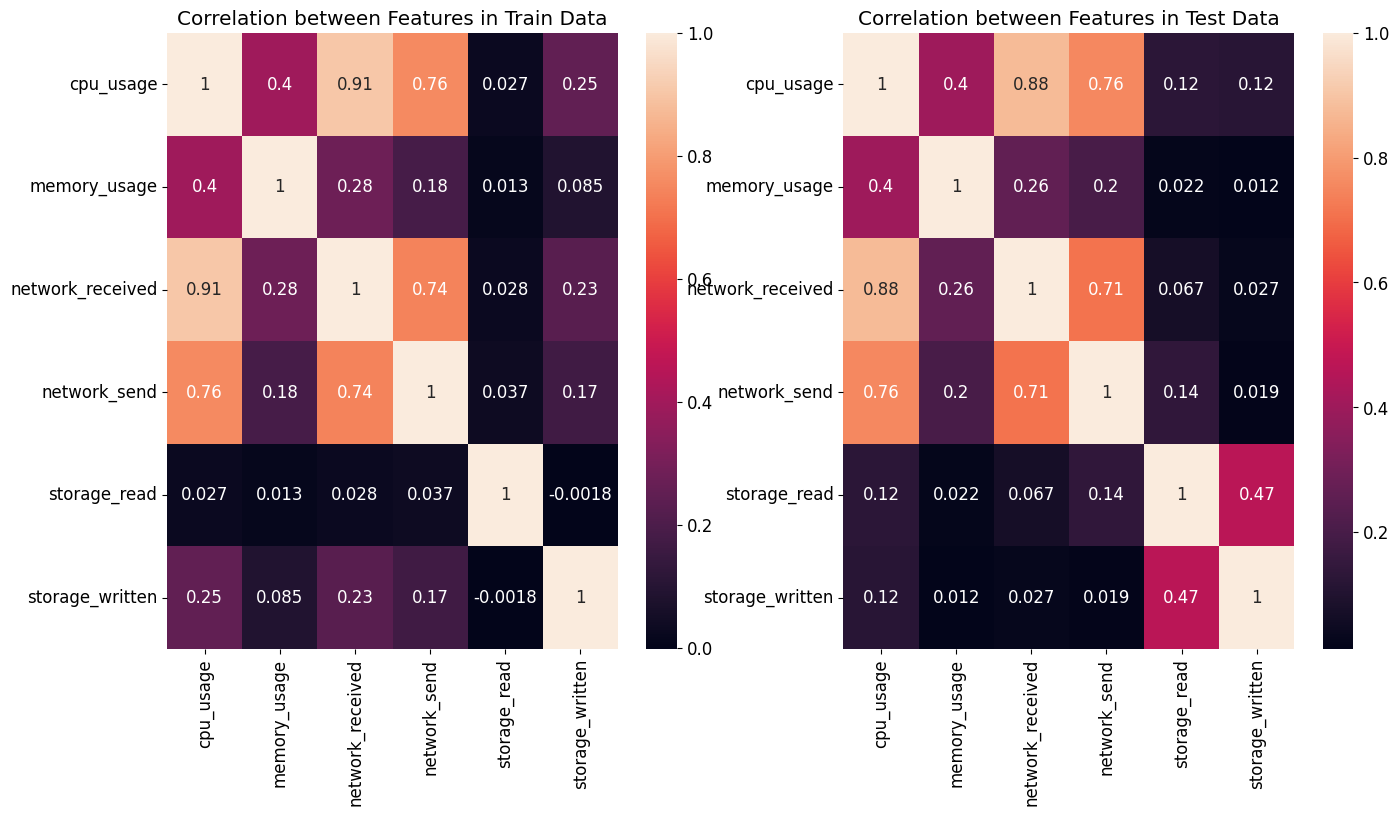

In [37]:
# Correlation of all features -> Scaling after does not make a difference
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.heatmap(train.corr(), annot=True)
plt.title("Correlation between Features in Train Data")
plt.subplot(1, 2, 2)
sns.heatmap(test.corr(), annot=True)
plt.title("Correlation between Features in Test Data")

### Time Series Data 

In [38]:
# Calculate time delta for data sets
train = calc_time_delta(train)
test = calc_time_delta(test)
validation = calc_time_delta(validation)

We split the data by the container and create a dataframe for each container

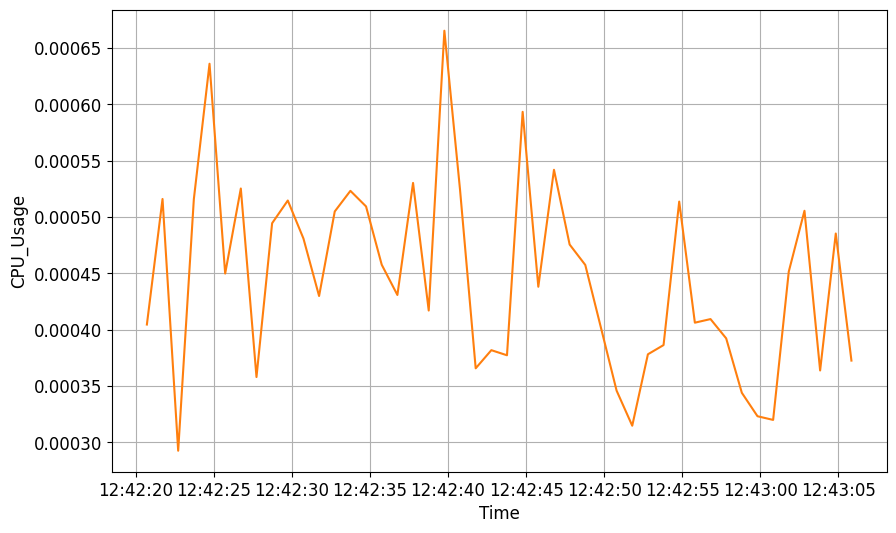

In [39]:
dfs_train = split_by_container(train)
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(dfs_train[3].index, dfs_train[3].cpu_usage, color='tab:orange')
# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('CPU_Usage')
ax.grid(True)
plt.show()


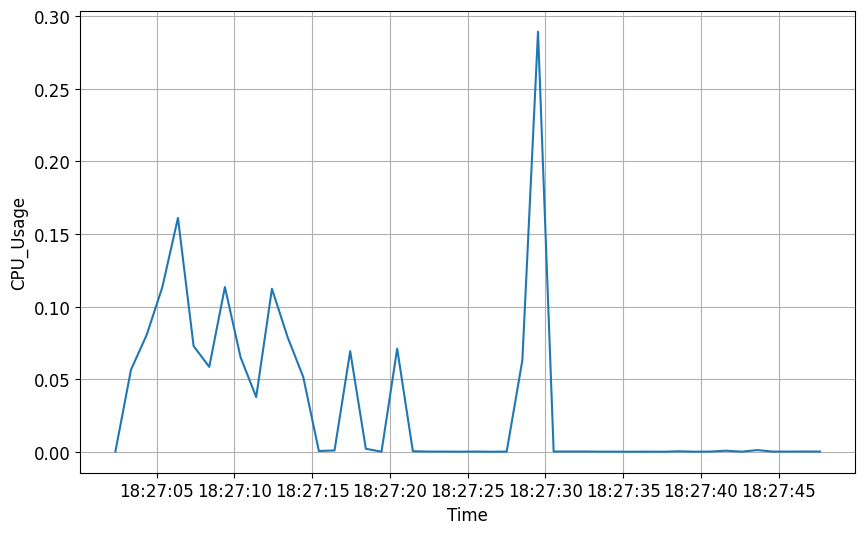

In [40]:
dfs_test = split_by_container(test)
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(dfs_test[3].index, dfs_test[3].cpu_usage, color='tab:blue')
# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('CPU_Usage')
ax.grid(True)
plt.show()


#### PACF and ACF

### Model1: IsolationForest

In [41]:
# Split and encode Data for modelling and evaluation
validation = encode(validation)
test = encode(test)
train = encode(train)
y_true_train = create_y_values(train)
y_true_test = create_y_values(test)
y_true_validation = create_y_values(validation)
X_train = select_columns_for_modelling(train)
X_test = select_columns_for_modelling(test)
X_validation = select_columns_for_modelling(validation)

In [42]:
# known in advance for contmination_rate
contamination_rate_train = calculate_anomalous_rate(train);print(contamination_rate_train)
contamination_rate_test = calculate_anomalous_rate(test);print(contamination_rate_test)
contamination_rate_validation = calculate_anomalous_rate(validation); print(contamination_rate_validation)

0.0
0.1532595823344213
0.0


### Experiment1: Fit model on train data and then get predictions for train data. Nothing should be detected.

In [43]:
model_type='IsolationForest'
IsoForest = load_model(model_type=model_type, X=X_train)
X_train = X_train.copy()
y_predictions_train_data, score_train_data, X_train_with_preds = predict_(IsoForest, X_train)

In [44]:
outliers_train=X_train_with_preds.loc[X_train_with_preds['anomaly']==1]
outlier_index_ts_train=list(outliers_train.index)
outliers_train = outliers_train.reset_index()
outlier_index_train = list(outliers_train.index)
#Find the number of anomalies and normal points here points classified 1 are anomalous
print(X_train_with_preds['anomaly'].value_counts())

0    8100
1    1464
Name: anomaly, dtype: int64


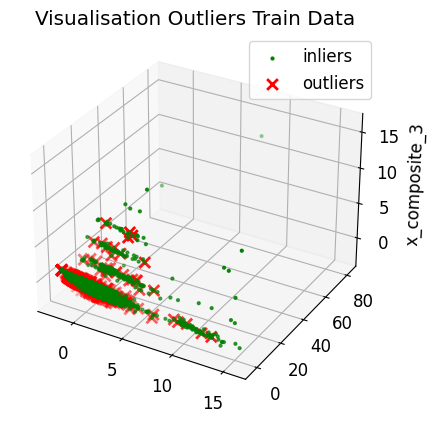

In [45]:
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(X_train)
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index_train,0],X_reduce[outlier_index_train,1], X_reduce[outlier_index_train,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
plt.title('Visualisation Outliers Train Data')
ax.legend()
plt.show()

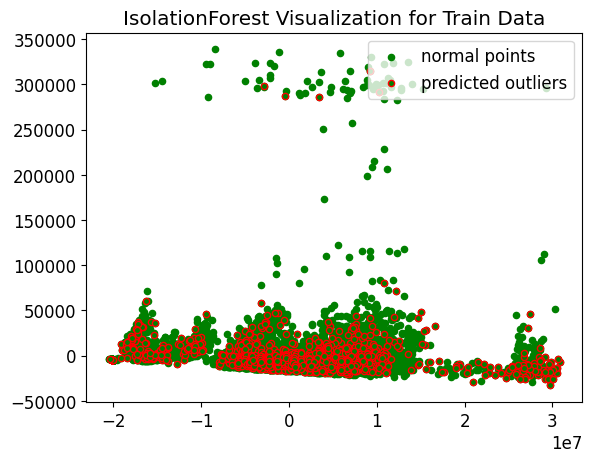

In [46]:
pca = PCA(2)
pca.fit(X_train)
res=pd.DataFrame(pca.transform(X_train))
Z = np.array(res)
plt.title("IsolationForest Visualization for Train Data")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index_train,0],res.iloc[outlier_index_train,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

### Experiment2: Fit model on training data and then get predictions for test data

In [47]:
# Call Model fit it with training data and get predictions for Test Data 
model_type='IsolationForest'
IsoForest = load_model(model_type=model_type, X=X_train)
X_test = X_test.copy()
y_predictions_test_data, score_test_data, X_test_with_preds = predict_(IsoForest, X_test)

In [48]:
outliers_test=X_test_with_preds.loc[X_test_with_preds['anomaly']==1]
outlier_index_ts_test=list(outliers_test.index)
outliers_test = outliers_test.reset_index()
outlier_index_test = list(outliers_test.index)
#Find the number of anomalies and normal points here points classified 1 are anomalous
print(X_test_with_preds['anomaly'].value_counts())

0    31537
1     8390
Name: anomaly, dtype: int64


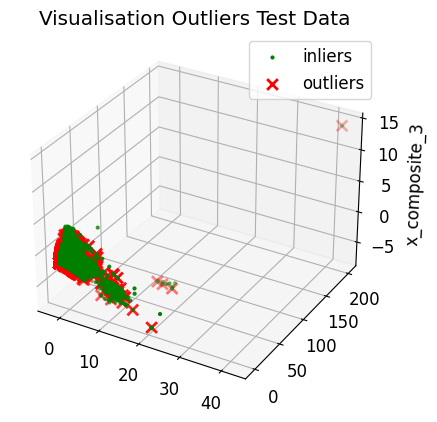

In [49]:
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(X_test)
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index_test,0],X_reduce[outlier_index_test,1], X_reduce[outlier_index_test,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
plt.title('Visualisation Outliers Test Data')
ax.legend()
plt.show()

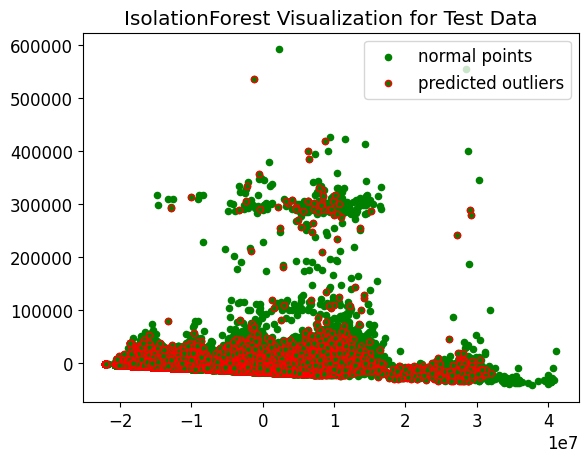

In [50]:
pca = PCA(2)
pca.fit(X_test)
res=pd.DataFrame(pca.transform(X_test))
Z = np.array(res)
plt.title("IsolationForest Visualization for Test Data")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index_test,0],res.iloc[outlier_index_test,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

### Experiment3: Fit Model on train data and get predictions for validation data.

In [51]:
model_type='IsolationForest'
IsoForest = load_model(model_type=model_type, X=X_train)
X_validation = X_validation.copy()
y_predictions_validation_data, score_validation_data, X_validation_with_preds = predict_(IsoForest, X_validation)

In [52]:
outliers_validation=X_validation_with_preds.loc[X_validation_with_preds['anomaly']==1]
outlier_index_ts_validation=list(outliers_validation.index)
outliers_validation = outliers_validation.reset_index()
outlier_index_validation = list(outliers_validation.index)
#Find the number of anomalies and normal points here points classified 1 are anomalous
print(X_validation_with_preds['anomaly'].value_counts())

0    2061
1     542
Name: anomaly, dtype: int64


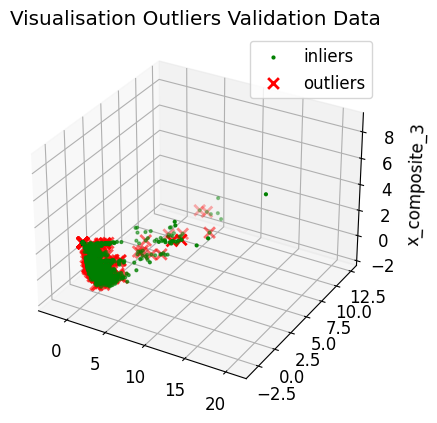

In [53]:
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(X_validation)
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index_validation,0],X_reduce[outlier_index_validation,1], X_reduce[outlier_index_validation,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
plt.title('Visualisation Outliers Validation Data')
ax.legend()
plt.show()

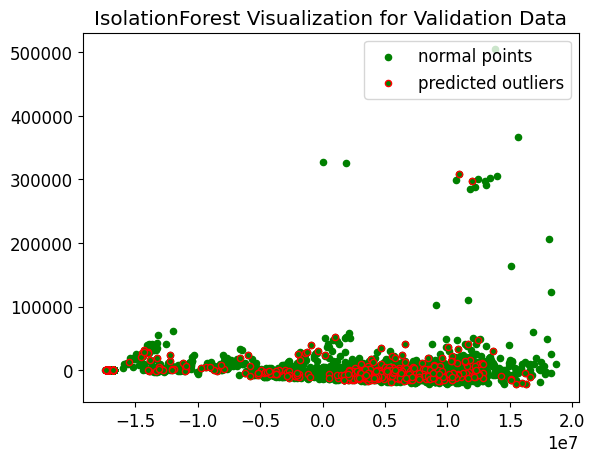

In [54]:
pca = PCA(2)
pca.fit(X_validation)
res=pd.DataFrame(pca.transform(X_validation))
Z = np.array(res)
plt.title("IsolationForest Visualization for Validation Data")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index_validation,0],res.iloc[outlier_index_validation,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

We further look into the score functions

#### Model2: LocalOutlierFactor

As we want to evaluate if our data set represents normal behavoiur in a good manner we have to assume that the training data is not polluted by outliers and we are interested in detecting whether a new observation is an outlier. In this context an outlier is also called a novelty.

In [55]:
model_type='LocalOutlierFactor'
LOF = load_model(model_type=model_type, X=X_train)
X_train = X_train.copy()
y_predictions_train_data, score_train_data, X_train_with_preds = predict_(LOF, X_train)

#### Model3: SOM + RNN https://conferences.oreilly.com/artificial-intelligence/ai-ny-2018/public/schedule/detail/64889.html

# Evaluation of Models

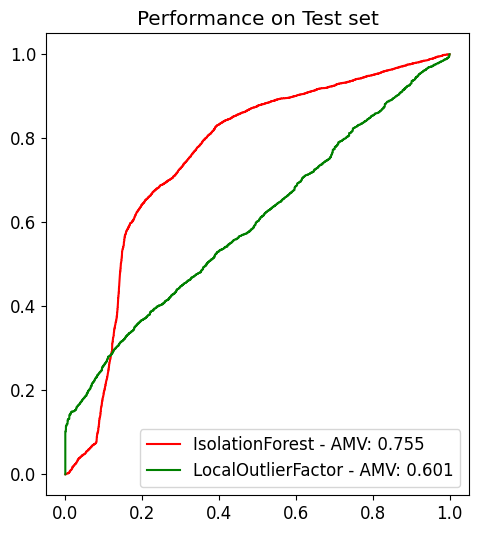

In [56]:
algorithms = [IsoForest, LOF]
name = ['IsolationForest', 'LocalOutlierFactor'] # time series data ?; density?;
colors = ['red', 'green']

plt.figure(figsize=(12, 6))
for a, algo in enumerate(algorithms):
    algo.fit(X_train)
    algo_train = algo.decision_function(X_train)
    algo_test = algo.decision_function(X_test)
    algo_validation = algo.decision_function(X_validation)

    # as only one class available auc does not work -> Brier Score!
    #fpr_train_, tpr_train_, _ = roc_curve(y_true_train, -algo_train)
    #algo_auc_train = auc(fpr_train_, tpr_train_)
    
    fpr_test_, tpr_test_, _ = roc_curve(y_true_test, -algo_test, pos_label=1) # Kommt drauf an wie rum(?) nochmal genau reinschauen 
    algo_auc_test = auc(fpr_test_, tpr_test_)

    # as only one class available auc does not work -> Brier Score!
    #fpr_validation_, tpr_validation_, _ = roc_curve(y_true_validation, -algo_validation)
    #algo_auc_validation = auc(fpr_validation_, tpr_validation_)

    #plt.subplot(1, 2, 1)
    #plt.title('Performance on Training set')
    #plt.plot(fpr_train_, tpr_train_, color=colors[a], label= '{0} - AUC: {1:.3f}'.format(name[a], algo_auc_train))
    
    plt.subplot(1, 2, 2)
    plt.title('Performance on Test set')
    plt.plot(fpr_test_, tpr_test_, color=colors[a], label= '{0} - AMV: {1:.3f}'.format(name[a], algo_auc_test)) #AMV: Augmented Mass Volume Function # AUC ohne 1
    
    #plt.subplot(1, 2, 1)
    #plt.title('Performance on Validation set')
    #plt.plot(fpr_validation_, tpr_validation_, color=colors[a], label= '{0} - AUC: {1:.3f}'.format(name[a], algo_auc_validation))
    


plt.subplot(1, 2, 2)
plt.legend(loc=0)
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))



plt.show()

In [125]:
# Test Data 
algorithms = [(IsoForest, 'IsolationForest'),(LOF,'LocalOutlierFactor')]
# Confusion Matrices
cms = {}
scores = defaultdict(list)
for i, (algo, name) in enumerate(algorithms):
    scores["Algorithm"].append(name)
    algo.fit(X_train)
    y_prediction, _, _ = predict_(algo, X_test)
    # Calculation of confusion matrix
    C = confusion_matrix(y_true_test, y_prediction)
    dict_ = {name:C}
    cms.update(dict_)
    for metric in [brier_score_loss]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_true_test, y_prediction))

    for metric in [precision_score, recall_score, f1_score, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_true_test, y_prediction))

    score_df = pd.DataFrame(scores).set_index("Algorithm")
    score_df.round(decimals=3)

score_df

,Brier loss,Precision,Recall,F1,Roc auc
Algorithm,,,,,
IsolationForest,0.191850,0.359714,0.56879,0.440713,0.706812
LocalOutlierFactor,0.244972,0.228096,0.35375,0.277355,0.585139


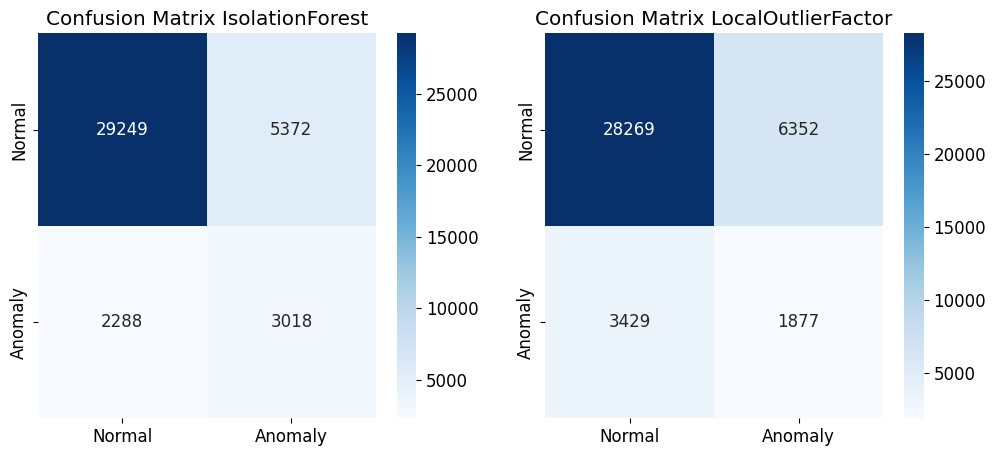

In [129]:
# Figure 1
# True Negative: Top Left
# False Postive: Top Right
# False Negative: Bottom Left
# True Positive: Bottom Right
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cms['IsolationForest'], annot=True,
            fmt='2', cmap='Blues', ax = axes[0],
            xticklabels=['Normal', "Anomaly"], yticklabels=['Normal', "Anomaly"])
axes[0].set_title("Confusion Matrix IsolationForest")


sns.heatmap(cms['LocalOutlierFactor'], annot=True, 
            fmt='2', cmap='Blues', ax= axes[1],
            xticklabels=['Normal', "Anomaly"], yticklabels=['Normal', "Anomaly"])
axes[1].set_title("Confusion Matrix LocalOutlierFactor")
plt.show()

In [152]:
# NOCHMAL vernünftig coden!
# get rates
true_negative = cms["IsolationForest"][0,0]
false_positve = cms["IsolationForest"][0,1]
false_negative = cms["IsolationForest"][1,0]
true_positve = cms["IsolationForest"][1,0]
# Sensitivity, hit rate, recall, or true positive rate
TPR = true_positve/(true_positve+false_negative)
# Specificity or true negative rate
TNR = true_negative/(true_negative+false_positve) 
# Precision or positive predictive value
PPV = true_positve/(true_positve+false_positve)
# Negative predictive value
NPV = true_negative/(true_negative+false_negative)
# Fall out or false positive rate
FPR = false_positve/(false_positve+true_negative)
# False negative rate
FNR = false_negative/(true_positve+false_negative)
# False discovery rate
FDR = false_positve/(true_positve+false_positve)

# Overall accuracy
ACC = (true_positve+true_negative)/(true_positve+false_positve+false_negative+true_negative)
print("*****IForest****")
print("False Positive Rate: {}".format(FPR)) # good because this means that 15% of the anomalies detected were in fact, not anomalous at all.
print("False Negative Rate: {}".format(FNR)) # This means that the system missed 50% of all anomalies in the data.

# get rates
true_negative = cms["LocalOutlierFactor"][0,0]
false_positve = cms["LocalOutlierFactor"][0,1]
false_negative = cms["LocalOutlierFactor"][1,0]
true_positve = cms["LocalOutlierFactor"][1,0]
# Sensitivity, hit rate, recall, or true positive rate
TPR = true_positve/(true_positve+false_negative)
# Specificity or true negative rate
TNR = true_negative/(true_negative+false_positve) 
# Precision or positive predictive value
PPV = true_positve/(true_positve+false_positve)
# Negative predictive value
NPV = true_negative/(true_negative+false_negative)
# Fall out or false positive rate
FPR = false_positve/(false_positve+true_negative)
# False negative rate
FNR = false_negative/(true_positve+false_negative)
# False discovery rate
FDR = false_positve/(true_positve+false_positve)

# Overall accuracy
ACC = (true_positve+true_negative)/(true_positve+false_positve+false_negative+true_negative)
print("*****LOF****")
print("False Positive Rate: {}".format(FPR)) # good because this means that 15% of the anomalies detected were in fact, not anomalous at all.
print("False Negative Rate: {}".format(FNR)) # This means that the system missed 50% of all anomalies in the data.

*****IForest****
False Positive Rate: 0.15516593974755205
False Negative Rate: 0.5
*****LOF****
False Positive Rate: 0.18347245891222091
False Negative Rate: 0.5


In [89]:
# Validation Data 
algorithms = [(IsoForest, 'IsolationForest'),(LOF,'LocalOutlierFactor')]
cms = {}
scores = defaultdict(list)
for i, (algo, name) in enumerate(algorithms):
    scores["Algorithm"].append(name)
    algo.fit(X_train)
    y_prediction, _, _ = predict_(algo, X_validation)
    # Calculation of confusion matrix
    C = confusion_matrix(y_true_validation, y_prediction)
    dict_ = {name:C}
    cms.update(dict_)
    # Metrics
    for metric in [brier_score_loss]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_true_validation, y_prediction))
    
    for metric in [precision_score, recall_score, f1_score, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        try:
            scores[score_name].append(metric(y_true_validation, y_prediction))
        except ValueError: # Only one class label available so metrics can't be computed correctly
            scores[score_name].append(0)
            

    score_df = pd.DataFrame(scores).set_index("Algorithm")
    score_df.round(decimals=3)

score_df

,Brier loss,Precision,Recall,F1,Roc auc
Algorithm,,,,,
IsolationForest,0.208221,0.0,0.0,0.0,0
LocalOutlierFactor,0.304264,0.0,0.0,0.0,0


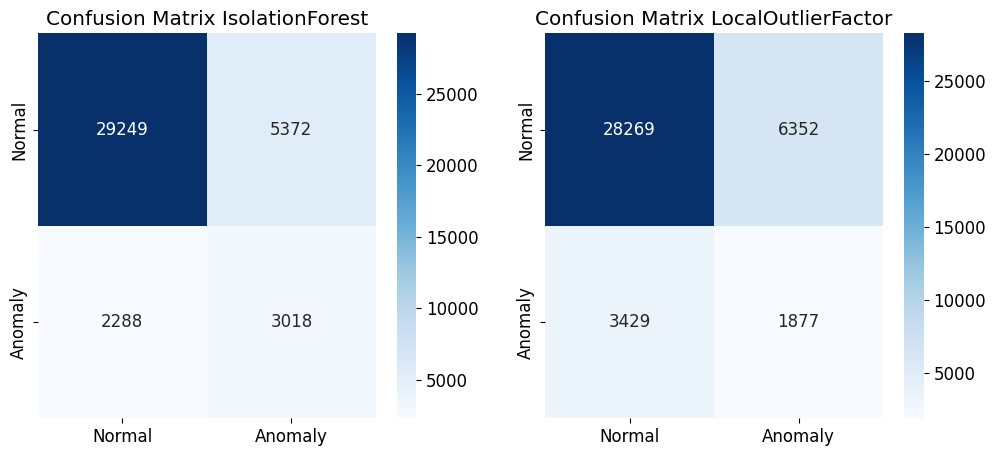

In [131]:
# Figure 2
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cms['IsolationForest'], annot=True, 
            fmt='2', cmap='Blues', ax = axes[0],
            xticklabels=['Normal', "Anomaly"], yticklabels=['Normal', "Anomaly"])
axes[0].set_title("Confusion Matrix IsolationForest")


sns.heatmap(cms['LocalOutlierFactor'], annot=True, 
            fmt='2', cmap='Blues', ax= axes[1],
            xticklabels=['Normal', "Anomaly"], yticklabels=['Normal', "Anomaly"])
axes[1].set_title("Confusion Matrix LocalOutlierFactor")
plt.show()

## Consideration of all data sets in the LID-DS